# Domain Adaptation
### Author: Pietro Gori

As for all TP, answer all questions and fill the code where you see **XXXXXXXXX**

**Deadline**: please verify on the Moodle/Ecampus/web site the deadline

**Author**: Naïl Khelifa

In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
## Standard libraries
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

## PyTorch
import torch

## Torchvision
import torchvision
from torchvision.datasets import SVHN, MNIST, USPS
import torchvision.transforms as T
from torch.utils.data import DataLoader

## Sklearn
from sklearn.manifold import TSNE

## UMAP
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  print("Using Google Colab")
  !pip install umap-learn
  from umap import UMAP
  !pip install adapt
  !pip install Tensorflow==2.15
else:
  from umap import UMAP  

# Path to the folder where the datasets are/should be downloaded
DATASET_PATH = "./data"

In [ ]:
print("Using torch", torch.__version__)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print ("MPS (MacBook) device found.")
    print('Number of MPS cards: ', torch.mps.device_count())
    print('Total MPS memory {0:.2f} GB'.format(torch.mps.recommended_max_memory()/pow(10,9)))
elif torch.backends.cuda.is_built():
    device = torch.device("cuda")
    # Ensure that all operations are deterministic on GPU (if used) for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print ("CUDA device found.")
    print('Number of GPU cards: ', torch.cuda.device_count(), '\nWhich card GPU?', torch.cuda.get_device_name(0))
    print('Total GPU memory {1:.2f} GB. Free GPU memory {0:.2f} GB'.format(torch.cuda.mem_get_info()[0]/pow(10,9),torch.cuda.mem_get_info()[1]/pow(10,9)))
else:
   device = torch.device("cpu")
   print('No MPS or CUDA has been found. PyTorch will use CPU.')

Using torch 2.2.2
No MPS or CUDA has been found. PyTorch will use CPU.


In this practical session you will implement and test the method presented in [1] for Unsupervised Domain Adaptation.

You will use three imaging datasets showing 0-9 digits: MNIST, SVHN and USPS.

We know that the output spaces are equal (same labels/classes), namely the digits from 0 to 9, and we will resize the data so that the input spaces are also equal (same number of pixels per image).

In this TP, you will assume a covariate shift and therefore that there is a shift between the marginal disitributions $p_S(X)$ and $p_T(X)$ and that the conditionl distributions $p_S(Y|X)$ and $p_t(Y|X)$ are equal.

As for the other TP, answer all questions and fill the code where you see **XXXXXXXXX**

**Deadline**: please verify on the Moodle/Ecampus the deadline



[1] B. Fernando et al. “Unsupervised Visual Domain Adaptation Using Subspace Alignment”. In: ICCV. 2013.

### **MNIST**

 Let's start by downloading the **MNIST** dataset: a very common and large database of grayscale images showing handwritten digits ranging from 0 to 9. It comprises 60,000 training images and 10,000 testing images of size 28x28.

To cope with the assumption about the "same number of input pixels per image", we choose the input dimension of 32x32 for all datasets. We thus resize all images (originally 28x28) using the padding function "Pad" (add 0 to the borders).


In [ ]:
# Transform to normalized Tensors in the range [0,1]
MNIST_train_dataset = MNIST(root=DATASET_PATH, train= True, download=True, transform=T.Compose([T.Pad(2), T.ToTensor()]))
MNIST_test_dataset = MNIST(root=DATASET_PATH, train= False, download=True, transform=T.Compose([T.Pad(2), T.ToTensor()]))

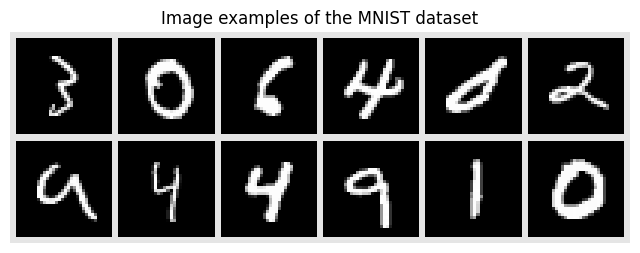

In [ ]:
# Visualize some examples
NUM_IMAGES = 12
MNIST_images = torch.stack([MNIST_train_dataset[np.random.randint(len(MNIST_train_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(MNIST_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the MNIST dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

Be careful ! Even if you put a transform when downloading the data and creating the Pytorch Dataset, this is actually not applied until you load the data with a DataLoader.

For instance, when you load images in the range $[0,255]$ and you put the transform `ToTensor()`, this should automatically normalize the images in the range $[0,1]$ and transform them into Pytorch tensors. However, if you simply take the data from the DataSet *WITHOUT* the DataLoader...

In [6]:
#This does not apply the normalization to [0-1] (transform To.Tensor() )
MNIST_Xtrain_255 = MNIST_train_dataset.data.numpy()
MNIST_ytrain_255 = MNIST_train_dataset.targets.numpy()


NameError: name 'MNIST_train_dataset' is not defined

In [7]:
print(MNIST_Xtrain_255.shape)
print(MNIST_ytrain_255.shape)

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(MNIST_Xtrain_255.min(), MNIST_Xtrain_255.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(MNIST_Xtrain_255.mean(), MNIST_Xtrain_255.std()))
print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(MNIST_Xtrain_255.min(), MNIST_Xtrain_255.max()))

(60000, 28, 28)
(60000,)
Min Pixel Value: 0 
Max Pixel Value: 255
Mean Pixel Value 33.318421449829934 
Pixel Values Std: 78.56748998339798
Min Pixel Value: 0 
Max Pixel Value: 255


Instead, if we load them with the Dataloader...

In [8]:
MNIST_train_loader = DataLoader(MNIST_train_dataset, batch_size=len(MNIST_train_dataset))
MNIST_test_loader = DataLoader(MNIST_test_dataset, batch_size=len(MNIST_test_dataset))

MNIST_Xtrain_ima = np.squeeze(next(iter(MNIST_train_loader))[0].numpy())
MNIST_ytrain = next(iter(MNIST_train_loader))[1].numpy()

MNIST_Xtest_ima = np.squeeze(next(iter(MNIST_test_loader))[0].numpy())
MNIST_ytest = next(iter(MNIST_test_loader))[1].numpy()


In [9]:
print(MNIST_Xtrain_ima.shape)
print(MNIST_ytrain.shape)

print(MNIST_Xtest_ima.shape)
print(MNIST_ytest.shape)

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(MNIST_Xtrain_ima.min(), MNIST_Xtrain_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(MNIST_Xtrain_ima.mean(), MNIST_Xtrain_ima.std()))

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(MNIST_Xtest_ima.min(), MNIST_Xtest_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(MNIST_Xtest_ima.mean(), MNIST_Xtest_ima.std()))

(60000, 32, 32)
(60000,)
(10000, 32, 32)
(10000,)
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.10003671795129776 
Pixel Values Std: 0.2752174437046051
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.10145653039216995 
Pixel Values Std: 0.2774091958999634


(12, 32, 32)


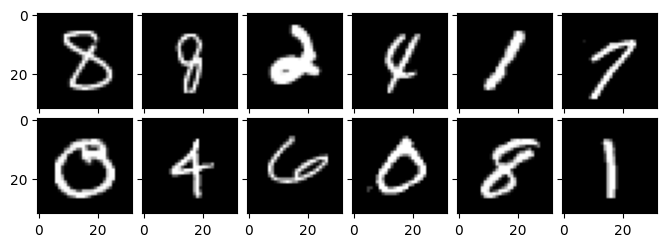

In [10]:
from mpl_toolkits.axes_grid1 import ImageGrid

NUM_IMAGES=12
MNIST_grid = MNIST_Xtrain_ima[np.random.randint(0,len(MNIST_Xtrain_ima),12),:,:]
print(MNIST_grid.shape)

fig = plt.figure(figsize=(8,8))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 6),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, MNIST_grid):
    # Iterating over the grid returns the Axes.
    ax.imshow(im,cmap='gray')

plt.show()

So we have 60k training images and 10K test images of size $[32 \times 32]$. Let's load another dataset

### **SVHN dataset**

The Street View House Numbers (SVHN) dataset is a real-world image dataset for house number detection. It is similar to MNIST since it has the same digit classes (0 to 9), but it is significantly harder due to its real-world setting. SVHN is obtained from house numbers in Google Street View images.

It comprises RGB images of size $32 \times 32$

We change them from RGB to grayscale to compare them with the MNIST images.


In [11]:
SVHN_train_dataset = SVHN(root=DATASET_PATH, split='train', download=True, transform=T.Compose([T.Grayscale(), T.ToTensor()]))
SVHN_test_dataset = SVHN(root=DATASET_PATH, split='test', download=True, transform=T.Compose([T.Grayscale(), T.ToTensor()]))

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


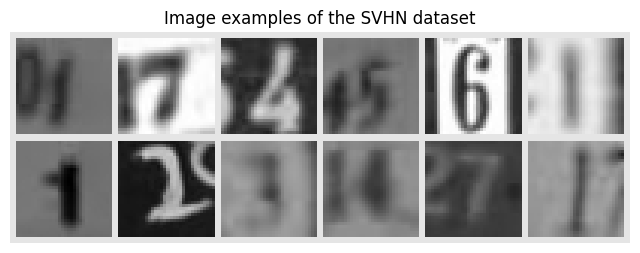

In [12]:
# Visualize some examples
NUM_IMAGES = 12
SVHN_images = torch.stack([SVHN_test_dataset[np.random.randint(len(SVHN_test_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(SVHN_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the SVHN dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [13]:
SVHN_train_loader = DataLoader(SVHN_train_dataset, batch_size=len(SVHN_train_dataset))
SVHN_test_loader = DataLoader(SVHN_test_dataset, batch_size=len(SVHN_test_dataset))

SVHN_Xtrain_ima = np.squeeze(next(iter(SVHN_train_loader))[0].numpy())
SVHN_ytrain = next(iter(SVHN_train_loader))[1].numpy()

SVHN_Xtest_ima = np.squeeze(next(iter(SVHN_test_loader))[0].numpy())
SVHN_ytest = next(iter(SVHN_test_loader))[1].numpy()


In [14]:
print(SVHN_Xtrain_ima.shape)
print(SVHN_ytrain.shape)
print(SVHN_Xtest_ima.shape)
print(SVHN_ytest.shape)

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(SVHN_Xtrain_ima.min(), SVHN_Xtrain_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(SVHN_Xtrain_ima.mean(), SVHN_Xtrain_ima.std()))

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(SVHN_Xtest_ima.min(), SVHN_Xtest_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(SVHN_Xtest_ima.mean(), SVHN_Xtest_ima.std()))

(73257, 32, 32)
(73257,)
(26032, 32, 32)
(26032,)
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.4452594220638275 
Pixel Values Std: 0.196975976228714
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.45435550808906555 
Pixel Values Std: 0.2220025360584259


Here we have ~73K training images and ~26K test images of the same size $[32 \times 32]$

### **USPS**

As last dataset, we will use the USPS dataset which contains images of digits (from 0 to 9) scanned from envelopes by the U.S. Postal Service. It contains a total of 9,298 $16 \times 16$ pixel grayscale images. Images are centered, normalized and show a broad range of font styles.

Even in ths case, we pad them with 0 in order to have $32 \times 32$ images.

In [15]:
USPS_train_dataset = USPS(root=DATASET_PATH, train= True, download=True, transform=T.Compose([T.Pad(8), T.ToTensor()]))
USPS_test_dataset = USPS(root=DATASET_PATH, train= False, download=True, transform=T.Compose([T.Pad(8), T.ToTensor()]))

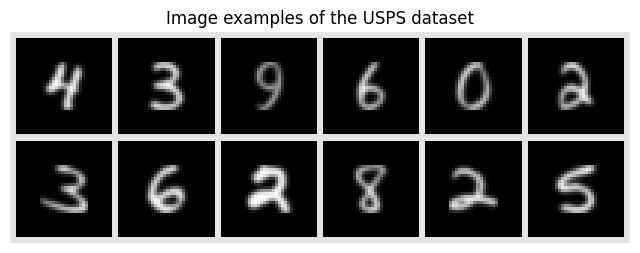

In [16]:
# Visualize some examples
NUM_IMAGES = 12
USPS_images = torch.stack([USPS_train_dataset[np.random.randint(len(USPS_train_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(USPS_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the USPS dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [17]:
USPS_train_loader = DataLoader(USPS_train_dataset, batch_size=len(USPS_train_dataset))
USPS_test_loader = DataLoader(USPS_test_dataset, batch_size=len(USPS_test_dataset))

USPS_Xtrain_ima = np.squeeze(next(iter(USPS_train_loader))[0].numpy())
USPS_ytrain = next(iter(USPS_train_loader))[1].numpy()

USPS_Xtest_ima = np.squeeze(next(iter(USPS_test_loader))[0].numpy())
USPS_ytest = next(iter(USPS_test_loader))[1].numpy()

In [18]:
print(USPS_Xtrain_ima.shape)
print(USPS_ytrain.shape)
print(USPS_Xtest_ima.shape)
print(USPS_ytest.shape)

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(USPS_Xtrain_ima.min(), USPS_Xtrain_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(USPS_Xtrain_ima.mean(), USPS_Xtrain_ima.std()))

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(USPS_Xtest_ima.min(), USPS_Xtest_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(USPS_Xtest_ima.mean(), USPS_Xtest_ima.std()))

(7291, 32, 32)
(7291,)
(2007, 32, 32)
(2007,)
Min Pixel Value: 0.0 
Max Pixel Value: 0.9960784316062927
Mean Pixel Value 0.06171923503279686 
Pixel Values Std: 0.18373751640319824
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.06497029960155487 
Pixel Values Std: 0.19083774089813232


We have ~7K training images and ~2k test images of size $[32 \times 32]$

### **UMAP**

One of the first things to do, is to visually check the data to verify if it exists a domain gap and if the datasets are different.

Here, we will use the UMAP and t-SNE methods which are general manifold learning and non-linear dimension reduction algorithms (probably the two most-used ones). UMAP can be seen as a Riemannian extension of the t-SNE method (which uses an Euclidean distance).

[1] Leland McInnes, John Healy, James Melville. "UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction". 2018

[2] van der Maaten, L.J.P., Hinton, G.E. "Visualizing Data Using t-SNE". Journal of Machine Learning Research. 2008


Transform data so that instead than having 3D arrays of images we will have 2D arrays by vectorizing each image -> $32 \times 32 = 1024$

In [19]:
# MNIST
MNIST_Xtrain = MNIST_Xtrain_ima.reshape(MNIST_Xtrain_ima.shape[0], -1)  # Flatten to (num_samples, 1024)
MNIST_Xtest = MNIST_Xtest_ima.reshape(MNIST_Xtest_ima.shape[0], -1)    # Flatten to (num_samples, 1024)

print(MNIST_Xtrain.shape, MNIST_Xtest.shape)  # Should output (num_samples, 1024)

# USPS
USPS_Xtrain = USPS_Xtrain_ima.reshape(USPS_Xtrain_ima.shape[0], -1)  # Flatten to (num_samples, 1024)
USPS_Xtest = USPS_Xtest_ima.reshape(USPS_Xtest_ima.shape[0], -1)    # Flatten to (num_samples, 1024)

print(USPS_Xtrain.shape, USPS_Xtest.shape)  # Should output (num_samples, 1024)

# SVHN
SVHN_Xtrain = SVHN_Xtrain_ima.reshape(SVHN_Xtrain_ima.shape[0], -1)  # Flatten to (num_samples, 1024)
SVHN_Xtest = SVHN_Xtest_ima.reshape(SVHN_Xtest_ima.shape[0], -1)    # Flatten to (num_samples, 1024)

print(SVHN_Xtrain.shape, SVHN_Xtest.shape)  # Should output (num_samples, 1024)

(60000, 1024) (10000, 1024)
(7291, 1024) (2007, 1024)
(73257, 1024) (26032, 1024)


Here, we randomly pick only 1000 samples per dataset for visualization and to reduce the computational burden.

In [20]:
def randomly_sample_data(X, y, num_samples=1000, random_seed=42):
    np.random.seed(random_seed)  # Set seed for reproducibility
    indices = np.random.choice(X.shape[0], num_samples, replace=False)  # Random unique indices
    return X[indices], y[indices]  # Subset data and labels


# Reduced MNIST
MNIST_Xtrain_res, MNIST_ytrain_res = randomly_sample_data(MNIST_Xtrain, MNIST_ytrain)

# Reduced USPS
USPS_Xtrain_res, USPS_ytrain_res = randomly_sample_data(USPS_Xtrain, USPS_ytrain)

# Reduced SVHN
SVHN_Xtrain_res, SVHN_ytrain_res = randomly_sample_data(SVHN_Xtrain, SVHN_ytrain)


# Reduced Data
xtot=np.concatenate((MNIST_Xtrain_res,USPS_Xtrain_res,SVHN_Xtrain_res),axis=0) # all data
nMNIST=MNIST_Xtrain_res.shape[0]
nUSPS=USPS_Xtrain_res.shape[0]
nSVHN=SVHN_Xtrain_res.shape[0]

In [21]:
xp = UMAP().fit_transform(xtot) # this should take ~50sec

print(xp.shape)

# separate again but now in 2D
xpMNIST=xp[:nMNIST,:]
xpUSPS=xp[nMNIST:nMNIST+nUSPS,:]
xpSVHN=xp[nMNIST+nUSPS:,:]

(3000, 2)


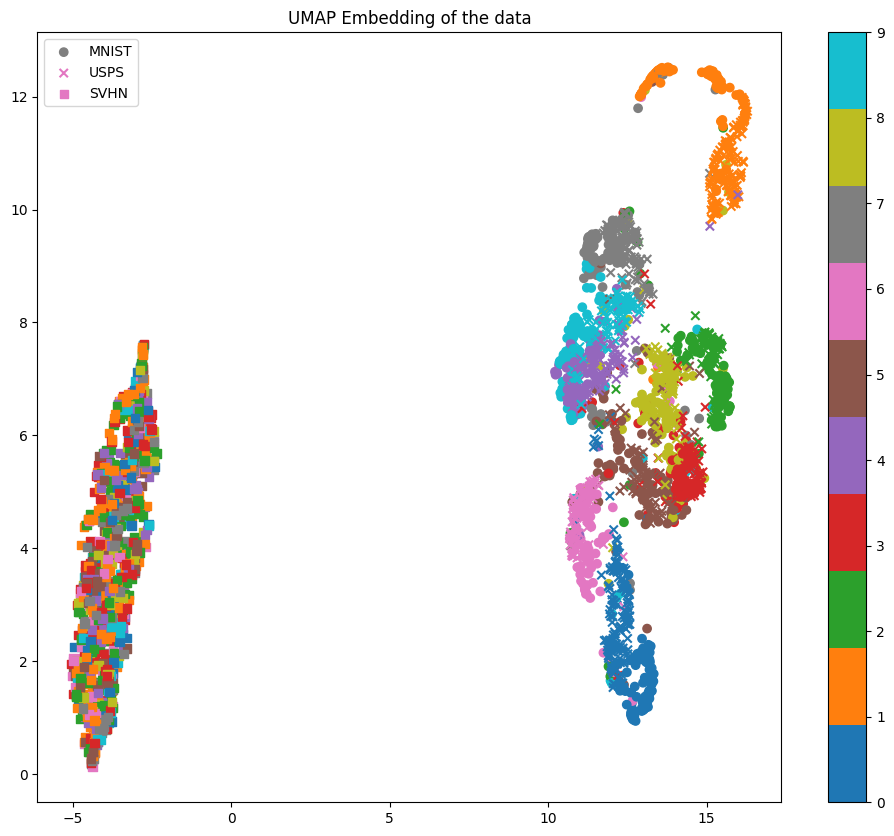

In [22]:
plt.figure(3,(12,10))

plt.scatter(xpMNIST[:,0],xpMNIST[:,1],c=MNIST_ytrain_res,marker='o',cmap='tab10',label='MNIST')
plt.scatter(xpUSPS[:,0],xpUSPS[:,1],c=USPS_ytrain_res,marker='x',cmap='tab10',label='USPS')
plt.scatter(xpSVHN[:,0],xpSVHN[:,1],c=SVHN_ytrain_res,marker='s',cmap='tab10',label='SVHN')
plt.legend()
plt.colorbar()
plt.title('UMAP Embedding of the data')
plt.show()

The embedding clearly separates the dataset with squares (SVHN) and the two other datasets (USPS, MNIST). 

It seems that one dataset is quite different from the other two.

**Question**: What are your conclusions ? Re-run the code showing only the most similar datasets.

One conclusion could be that there is a domain gap between SVHN and the two other datasets, and that this domain gap translates into metrically distant dataset in the embedding space. 

From this observation, a natural question would be to study more precisely the two datasets (USPS, MNIST) that are supposedly "close" in the UMAP representation. 

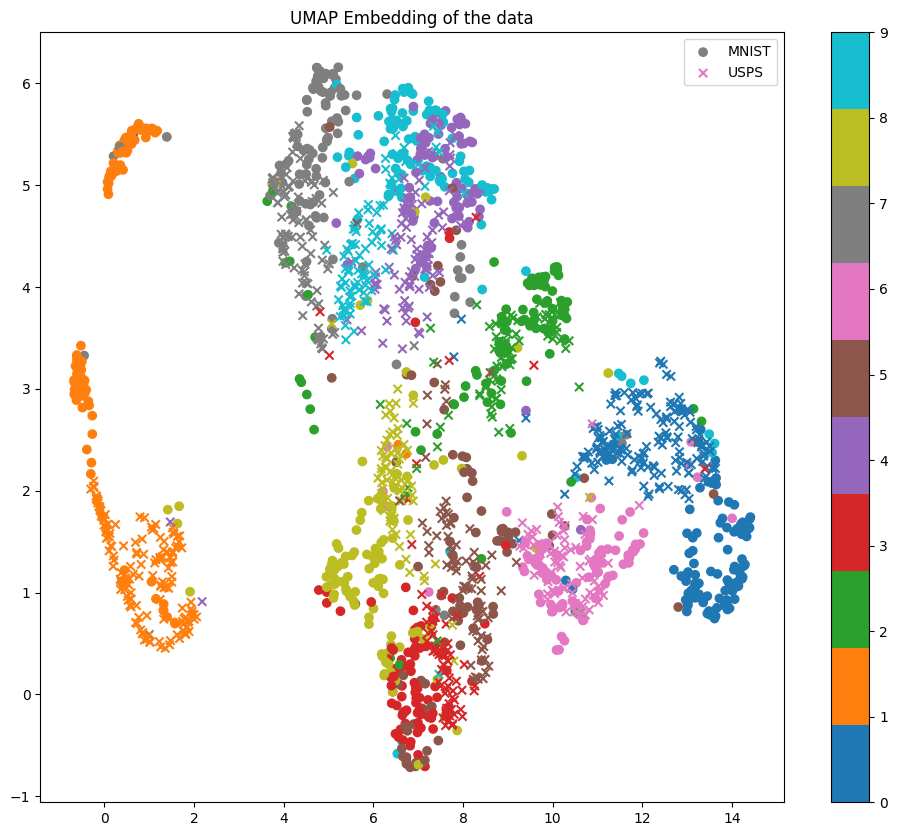

In [23]:
# Reduced Data
xtot2=np.concatenate((MNIST_Xtrain_res,USPS_Xtrain_res),axis=0) # all data
nMNIST2=MNIST_Xtrain_res.shape[0]
nUSPS2=USPS_Xtrain_res.shape[0]

xp2 = UMAP().fit_transform(xtot2) # this should take ~50sec

# separate again but now in 2D
xpMNIST2=xp2[:nMNIST2,:]
xpUSPS2=xp2[nMNIST2:,:]

plt.figure(3,(12,10))

plt.scatter(xpMNIST2[:,0],xpMNIST2[:,1],c=MNIST_ytrain_res,marker='o',cmap='tab10',label='MNIST')
plt.scatter(xpUSPS2[:,0],xpUSPS2[:,1],c=USPS_ytrain_res,marker='x',cmap='tab10',label='USPS')
plt.legend()
plt.colorbar()
plt.title('UMAP Embedding of the data')
plt.show()

We observe that classes are more clearly separated, however, no clear distinction between the two datasets is observable. On the contrary, it looks like the two dataset are coherent in the meaning that the classes of each of the two dataset seem to be similarly separated.

**Question**: Can you see a domain shift between the datasets ?

As previously concluded, there is not visible domain shift between the datasets MNIST and USPS. However, there is a domain shift between the two latter datasets and the SVHN dataset. 

Now we can test the t-SNE algorithm to check whether your conclusions are confirmed.

In [24]:
%time xp=TSNE().fit_transform(xtot) # this should take around 50 sec

print(xp.shape)

# separate again but now in 2D
xpMNIST=xp[:nMNIST,:]
xpUSPS=xp[nMNIST:nMNIST+nUSPS,:]
xpSVHN=xp[nMNIST+nUSPS:,:]
print(xpMNIST.shape,xpUSPS.shape,xpSVHN.shape)

CPU times: user 44.4 s, sys: 1.13 s, total: 45.6 s
Wall time: 27 s
(3000, 2)
(1000, 2) (1000, 2) (1000, 2)


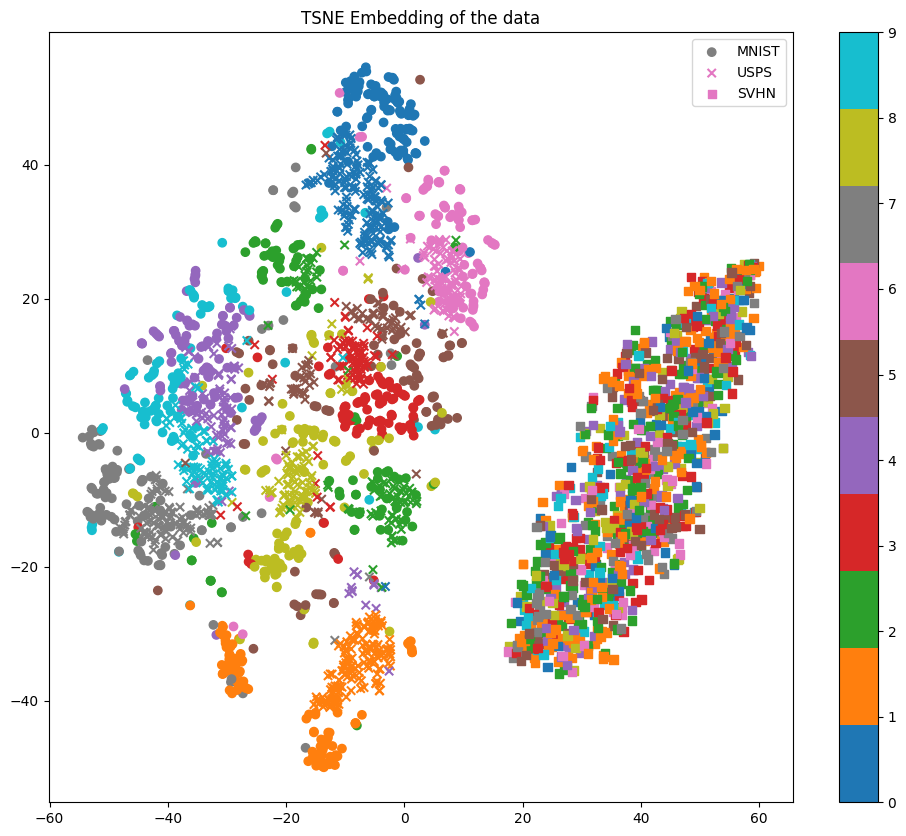

In [25]:
plt.figure(3,(12,10))

plt.scatter(xpMNIST[:,0],xpMNIST[:,1],c=MNIST_ytrain_res,marker='o',cmap='tab10',label='MNIST')
plt.scatter(xpUSPS[:,0],xpUSPS[:,1],c=USPS_ytrain_res,marker='x',cmap='tab10',label='USPS')
plt.scatter(xpSVHN[:,0],xpSVHN[:,1],c=SVHN_ytrain_res,marker='s',cmap='tab10',label='SVHN')
plt.legend()
plt.colorbar()
plt.title('TSNE Embedding of the data')
plt.show()

**Question**: can you confirm your previous conclusions ?

The previous conclusions are effectively confirmed.

It seems that one dataset is quite different from the other two data-sets.

**Question**: Analyse that dataset alone using UMAP (faster)

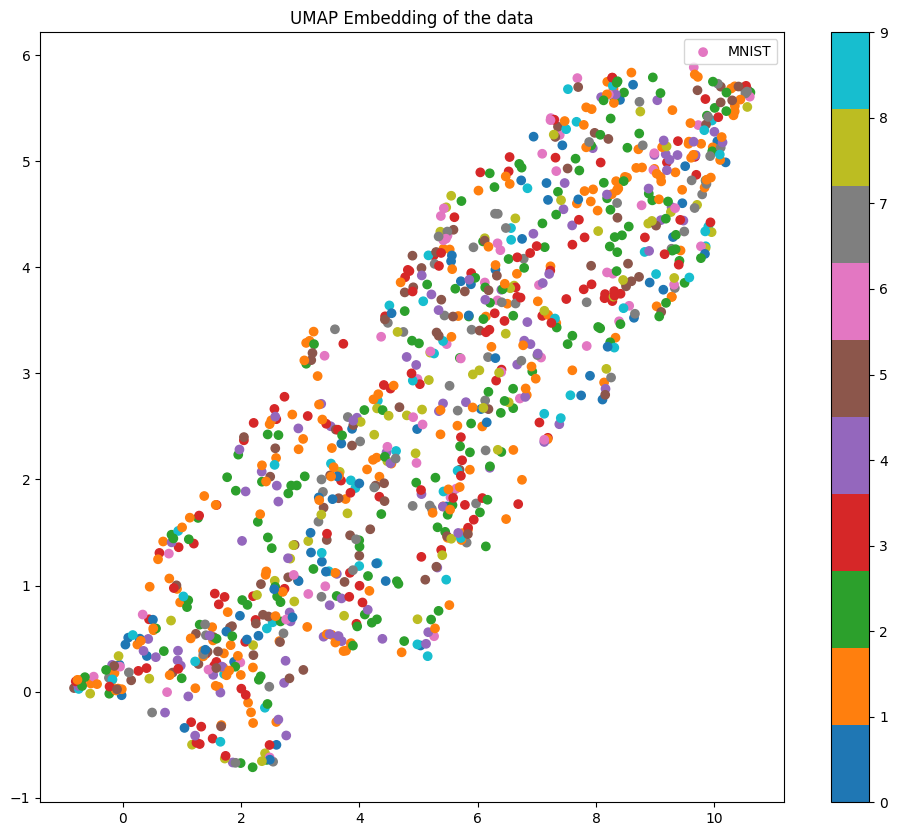

In [26]:
xp2 = UMAP().fit_transform(SVHN_Xtrain_res) 


plt.figure(3,(12,10))

plt.scatter(xp2[:,0],xp2[:,1],c=SVHN_ytrain_res,marker='o',cmap='tab10',label='MNIST')
plt.legend()
plt.colorbar()
plt.title('UMAP Embedding of the data')
plt.show()

**Question**: Are the data clearly clustered and well separated as for the other two datasets ? If not, why is that in your opinion ?

Hint: think about the input space of UMAP...

It is clearly disappointing. The data is not clearly clustered and well separated as for the other two datasets. I have two opinions on this: 

1. **Dimensionality Reduction Limitations**: UMAP projects data from a high-dimensional space (1024 in this case) to a lower-dimensional space (2 or 3 dimensions). Information loss during this process could result in overlapping clusters.

2. **Overcrowded Embedding**: If SVHN contains more data points or higher diversity within classes, the 2D space might not be sufficient to capture separability.

# Unsupervised Domain Adaptation

The three data-sets have the same features $\mathcal{X}$ (all images have size $[32 \times 32]$)
 and the same classes (output labels) $\mathcal{Y}$ but they have different marginal $p(X)$ distributions.

In this part, we will assume that we only have labeled data in the source domain $S$ but not int the target domain $T$. By matching the source $p_S(X)$ and target $p_T(X)$ marginal distributions, one can hope that a classifier learnt on $S$ will also work on $T$.

Here, you will implement and test the following algorithm based on subspace alignement:

B. Fernando et al. "*Unsupervised Visual Domain Adaptation Using Subspace Alignment*". ICCV, 2013.

The first thing to do is to choose the source domain and the target domain.
Let's start with the MNIST dataset as source and USPS as target.

We will use the previousyly computed reduced datasets to speed up computations.

In [3]:
# Source domain
XtrainS = MNIST_Xtrain_res
ytrainS = MNIST_ytrain_res
XtestS = MNIST_Xtest
ytestS = MNIST_ytest

# # Target domain
XtrainT = USPS_Xtrain_res
ytrainT = USPS_ytrain_res
XtestT = USPS_Xtest
ytestT = USPS_ytest

# Target domain
# XtrainT = SVHN_Xtrain_res
# ytrainT = SVHN_ytrain_res
# XtestT = SVHN_Xtest
# ytestT = SVHN_ytest

Ns=1000 # number of samples in source domain
Nt=1000 # number of samples in target domain

NameError: name 'MNIST_Xtrain_res' is not defined

Implement the method following the description of the method in the slides of the lecture (around slide 75).  

In [28]:
from sklearn.decomposition import PCA
import numpy as np

def SA(XTrainS, XTrainT, d=10):
    """
    Subspace Alignment (SA)

    Input:
    XTrainS : Input training source data [NTrS, D]
    XTestS : Input test source data [NTeS, D]
    XTrainT : Input training target data [NTrT, D]
    XTestT : Input test target data [NTeT, D]
    d : Number of PCA components

    Output:
    XTrainSp : Projected and transformed source training data [NTrS, d]
    XTestSp : Projected and transformed source test data [NTeS, d]
    XTrainTp : Projected training target data [NTrT, d]
    XTestTp : Projected test target data [NTeT, d]
    """
    # Step 1: Compute PCA on the source and target data
    pca_source = PCA(n_components=d)
    US = pca_source.fit(XTrainS).components_.T  # Source eigenvectors [D, d]

    pca_target = PCA(n_components=d)
    UT = pca_target.fit(XTrainT).components_.T  # Target eigenvectors [D, d]

    # Step 2: Compute the transformation matrix M
    M = US.T @ UT  # [d, d]

    # Step 3: Project and transform the source data
    XTrainSp = XTrainS @ US @ M  # [NTrS, D] * [D, d] * [d, d] = [NTrS, d]

    # Step 4: Project the target data
    XTrainTp = XTrainT @ UT  # [NTrT, D] * [D, d] = [NTrT, d]

    return XTrainSp, XTrainTp


We start by veryfying the score of a classifier trained on the source domain and tested on the target domain (no adaptation).

You can use the classifier you want (e.g., logistic regression, SVM, ...)

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

def train_and_test_source_to_target(XTrainS, yTrainS, XTrainT, yTrainT, type="log_reg"):
    """
    Train a classifier on the source domain and test it on the target domain (no adaptation).
    
    Parameters:
    - XTrainS: Training data from source domain
    - yTrainS: Labels for source training data
    - XTestT: Test data from target domain
    - yTestT: Labels for target test data
    
    Returns:
    - accuracy: Accuracy of the classifier on the target domain
    """

    # Step 1: Initialize and train the classifier
    if type == "log_reg":
        classifier = LogisticRegression(max_iter=1000)
        classifier.fit(XTrainS, yTrainS)
    elif type == "svm":
        classifier = SVC(kernel='linear')  # or 'rbf' depending on your preference
        classifier.fit(XTrainS, yTrainS)
    
    # Step 2: Predict on the target domain
    y_pred = classifier.predict(XTrainT)
    
    # Step 3: Compute accuracy
    accuracy = accuracy_score(yTrainT, y_pred)
    
    print(f"Accuracy on the target domain (no adaptation - {type}): {accuracy * 100:.2f}%")
    return accuracy

In [30]:
accuracy = train_and_test_source_to_target(XtrainS, ytrainS, XtrainT, ytrainT)
accuracy2 = train_and_test_source_to_target(XtrainS, ytrainS, XtrainT, ytrainT, type="svm")

Accuracy on the target domain (no adaptation - log_reg): 61.20%
Accuracy on the target domain (no adaptation - svm): 64.60%


To reduce dimensionality, we can also first compute PCA using the source training set and then project (i.e., transform) all data (source and target, training and test) on the first $d$ components.

**Question**: try different values of $d$. Is there a difference with the previous full-training data appraoch ?


Evaluating for d = 2 PCA components...
  Logistic Regression Accuracy: 0.2640
  SVM Accuracy: 0.2690
  MLP Accuracy: 0.2760

Evaluating for d = 5 PCA components...


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


  Logistic Regression Accuracy: 0.4200
  SVM Accuracy: 0.3980
  MLP Accuracy: 0.3810

Evaluating for d = 10 PCA components...
  Logistic Regression Accuracy: 0.5450
  SVM Accuracy: 0.5650
  MLP Accuracy: 0.5550

Evaluating for d = 20 PCA components...
  Logistic Regression Accuracy: 0.6280
  SVM Accuracy: 0.6350
  MLP Accuracy: 0.6270

Evaluating for d = 50 PCA components...
  Logistic Regression Accuracy: 0.6150
  SVM Accuracy: 0.6280
  MLP Accuracy: 0.6560

Evaluating for d = 70 PCA components...
  Logistic Regression Accuracy: 0.6210
  SVM Accuracy: 0.6240
  MLP Accuracy: 0.6430

Evaluating for d = 100 PCA components...
  Logistic Regression Accuracy: 0.6030
  SVM Accuracy: 0.6180
  MLP Accuracy: 0.6570

Evaluating for d = 120 PCA components...
  Logistic Regression Accuracy: 0.6090
  SVM Accuracy: 0.6160
  MLP Accuracy: 0.6550

Evaluating for d = 150 PCA components...
  Logistic Regression Accuracy: 0.6050
  SVM Accuracy: 0.6110
  MLP Accuracy: 0.6490

Evaluating for d = 200 PCA co

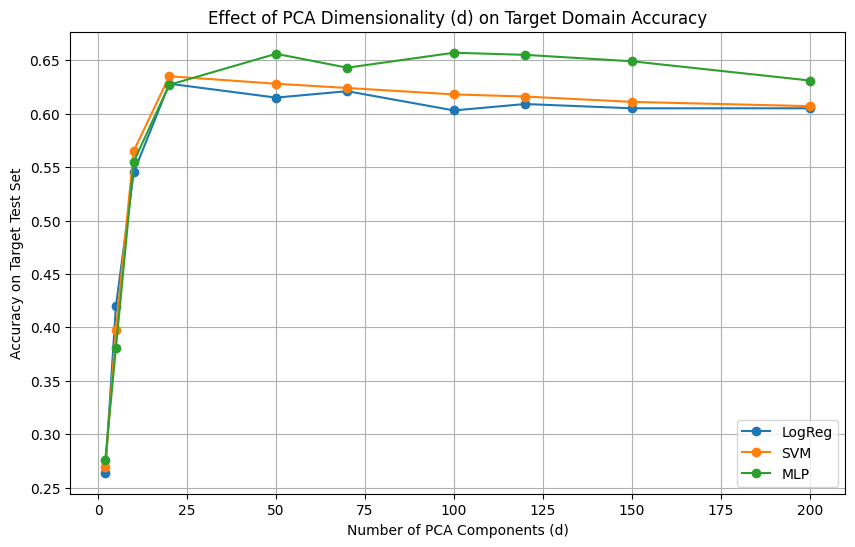


Comparing with Full-Dimensional Data Accuracy...
Full-Dimensional Data Accuracy (Logistic Regression): 0.5311


In [32]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

def pca_experiment_with_plot(XTrainS, XTrainT, yTrainS, yTrainT, d_values):
    """
    Test the effect of PCA dimensionality reduction on domain adaptation
    with Logistic Regression, SVM, and MLP, and plot the results.

    Parameters:
    - XTrainS, XTestS: Source domain training and test features
    - XTrainT, XTestT: Target domain training and test features
    - yTrainS, yTestT: Source training and target test labels
    - d_values: List of PCA dimensions to evaluate

    Returns:
    - results: Dictionary with accuracies for each model and value of d
    """
    results = {"LogReg": {}, "SVM": {}, "MLP": {}}

    for d in d_values:
        print(f"\nEvaluating for d = {d} PCA components...")

        # Step 1: Apply PCA using the source training data
        pca = PCA(n_components=d)
        pca.fit(XTrainS)

        # Step 2: Transform all datasets
        XTrainS_pca = pca.transform(XTrainS)
        XTrainT_pca = pca.transform(XTrainT)

        # Step 3: Train and evaluate models

        # Logistic Regression
        clf_logreg = LogisticRegression(max_iter=1000)
        clf_logreg.fit(XTrainS_pca, yTrainS)
        yPredT_logreg = clf_logreg.predict(XTrainT_pca)
        acc_logreg = accuracy_score(yTrainT, yPredT_logreg)
        results["LogReg"][d] = acc_logreg

        # SVM (RBF kernel)
        clf_svm = SVC(kernel='rbf', C=1)
        clf_svm.fit(XTrainS_pca, yTrainS)
        yPredT_svm = clf_svm.predict(XTrainT_pca)
        acc_svm = accuracy_score(yTrainT, yPredT_svm)
        results["SVM"][d] = acc_svm

        # MLP
        clf_mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
        clf_mlp.fit(XTrainS_pca, yTrainS)
        yPredT_mlp = clf_mlp.predict(XTrainT_pca)
        acc_mlp = accuracy_score(yTrainT, yPredT_mlp)
        results["MLP"][d] = acc_mlp

        # Print results for this d
        print(f"  Logistic Regression Accuracy: {acc_logreg:.4f}")
        print(f"  SVM Accuracy: {acc_svm:.4f}")
        print(f"  MLP Accuracy: {acc_mlp:.4f}")

    # Step 4: Plot results
    plt.figure(figsize=(10, 6))
    for model in results.keys():
        accuracies = list(results[model].values())
        plt.plot(d_values, accuracies, marker='o', label=model)
    plt.xlabel("Number of PCA Components (d)")
    plt.ylabel("Accuracy on Target Test Set")
    plt.title("Effect of PCA Dimensionality (d) on Target Domain Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

    return results

# Example Usage
# Assuming XTrainS, XTestS, XTrainT, XTestT, yTrainS, yTestT are pre-defined
d_values = [2, 5, 10, 20, 50, 70, 100, 120, 150, 200]
results = pca_experiment_with_plot(XtrainS, XtrainT, ytrainS, ytrainT, d_values)

# Compare with Full-Dimensional Data Accuracy
print("\nComparing with Full-Dimensional Data Accuracy...")
classifier_full = LogisticRegression(max_iter=1000)
classifier_full.fit(XtrainS, ytrainS)
yPredT_full = classifier_full.predict(XtestT)
full_accuracy = accuracy_score(ytestT, yPredT_full)
print(f"Full-Dimensional Data Accuracy (Logistic Regression): {full_accuracy:.4f}")

We can now test the SA approach.

**Question**: try different values of $d$. Does the performance improve on the target domain ? Try at least two different ML methods (one linear and one non-linear) and one DL architecture (it can be a pre-trained model or a simple architecture). What's the best ?


Evaluating for d = 2 PCA components...
  Logistic Regression Accuracy: 0.3470
  SVM Accuracy: 0.3620
  MLP Accuracy: 0.3740

Evaluating for d = 5 PCA components...
  Logistic Regression Accuracy: 0.1650
  SVM Accuracy: 0.4390
  MLP Accuracy: 0.2190

Evaluating for d = 10 PCA components...
  Logistic Regression Accuracy: 0.5730
  SVM Accuracy: 0.6770
  MLP Accuracy: 0.5070

Evaluating for d = 20 PCA components...
  Logistic Regression Accuracy: 0.6460
  SVM Accuracy: 0.7340
  MLP Accuracy: 0.6860

Evaluating for d = 50 PCA components...
  Logistic Regression Accuracy: 0.6730
  SVM Accuracy: 0.7380
  MLP Accuracy: 0.7190

Evaluating for d = 70 PCA components...
  Logistic Regression Accuracy: 0.7070
  SVM Accuracy: 0.7350
  MLP Accuracy: 0.7340

Evaluating for d = 100 PCA components...
  Logistic Regression Accuracy: 0.6950
  SVM Accuracy: 0.7280
  MLP Accuracy: 0.7430

Evaluating for d = 120 PCA components...
  Logistic Regression Accuracy: 0.7080
  SVM Accuracy: 0.7270
  MLP Accuracy:

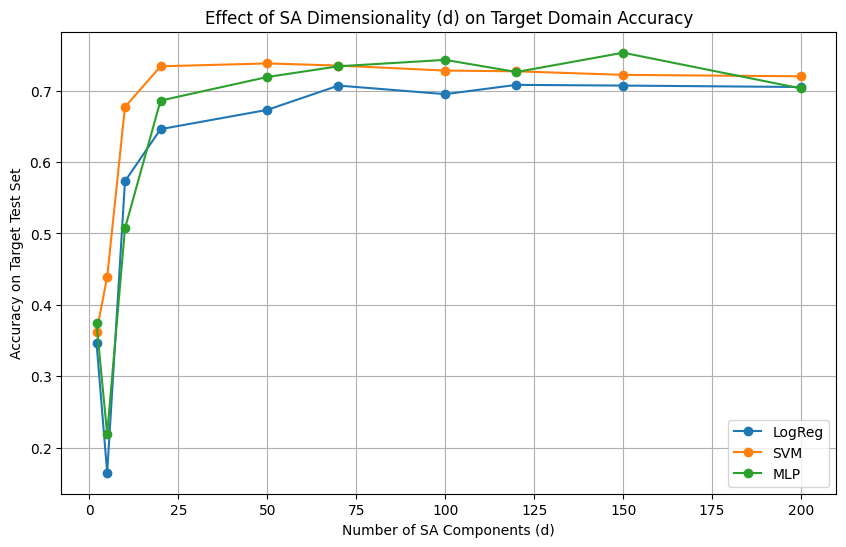

In [33]:
from sklearn.neural_network import MLPClassifier


# Define the experiment
def evaluate_SA(XTrainS, yTrainS, XTrainT, yTrainT, d_values):
    """
    Evaluate the performance of different models with Subspace Alignment for varying d.

    Parameters:
    - XTrainS, XTestS: Source domain training and test features
    - XTrainT, XTestT: Target domain training and test features
    - yTrainS, yTestT: Source training and target test labels
    - d_values: List of PCA dimensions to evaluate

    Returns:
    - results: Dictionary with accuracies for each model and value of d
    """
    results = {"LogReg": {}, "SVM": {}, "MLP": {}}

    for d in d_values:
        print(f"\nEvaluating for d = {d} PCA components...")
        
        # Apply Subspace Alignment
        XTrainSp, XTrainTp = SA(XTrainS, XTrainT, d=d)

        # Logistic Regression (Linear)
        clf_logreg = LogisticRegression(max_iter=1000)
        clf_logreg.fit(XTrainSp, yTrainS)
        yPredT_logreg = clf_logreg.predict(XTrainTp)
        acc_logreg = accuracy_score(yTrainT, yPredT_logreg)
        results["LogReg"][d] = acc_logreg

        # SVM (Non-linear)
        clf_svm = SVC(kernel='rbf', C=1)
        clf_svm.fit(XTrainSp, yTrainS)
        yPredT_svm = clf_svm.predict(XTrainTp)
        acc_svm = accuracy_score(yTrainT, yPredT_svm)
        results["SVM"][d] = acc_svm

        # MLP (Deep Learning)
        clf_mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
        clf_mlp.fit(XTrainSp, yTrainS)
        yPredT_mlp = clf_mlp.predict(XTrainTp)
        acc_mlp = accuracy_score(yTrainT, yPredT_mlp)
        results["MLP"][d] = acc_mlp

        # Print results for this d
        print(f"  Logistic Regression Accuracy: {acc_logreg:.4f}")
        print(f"  SVM Accuracy: {acc_svm:.4f}")
        print(f"  MLP Accuracy: {acc_mlp:.4f}")

    return results

# Example Usage
d_values =[2, 5, 10, 20, 50, 70, 100, 120, 150, 200]
results = evaluate_SA(XtrainS, ytrainS, XtrainT, ytrainT, d_values)

# Plotting the results
plt.figure(figsize=(10, 6))
for model in results.keys():
    accuracies = list(results[model].values())
    plt.plot(d_values, accuracies, marker='o', label=model)
plt.xlabel("Number of SA Components (d)")
plt.ylabel("Accuracy on Target Test Set")
plt.title("Effect of SA Dimensionality (d) on Target Domain Accuracy")
plt.legend()
plt.grid()
plt.show()


Results are better using the SA approach, and in the case of the SVM.

**Question**: Use the UMAP or t-SNE visualization to check whether the data are more similar after the SA adaptation. What can you conclude ?

Visualizing before Subspace Alignment - UMAP (SA)...


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


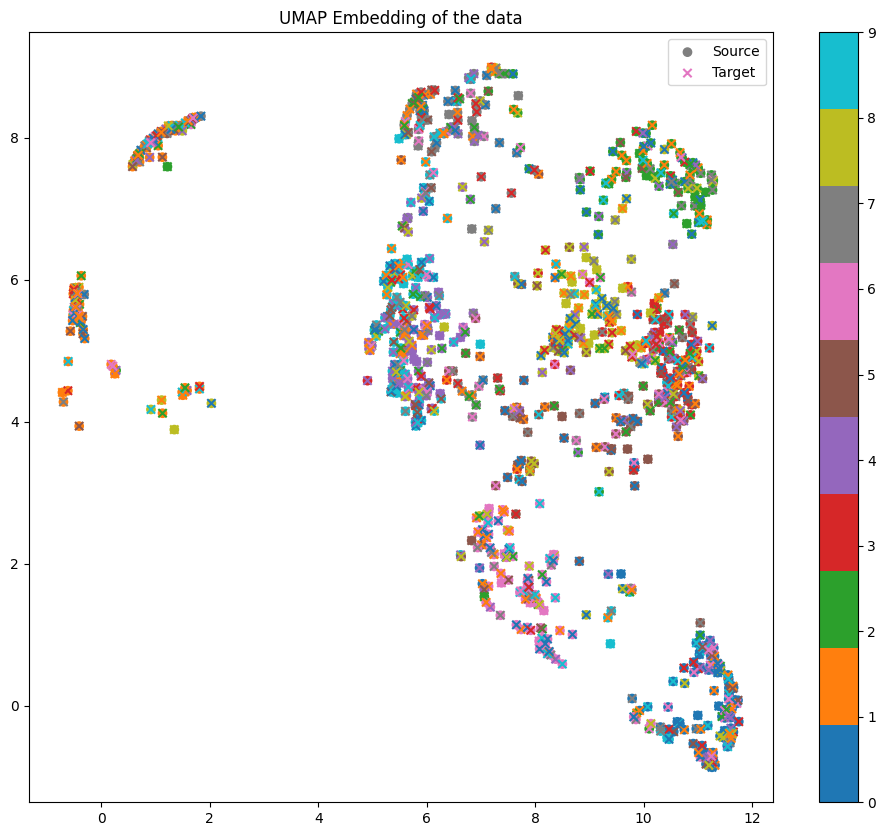

Applying Subspace Alignment ...
Visualizing after Subspace Alignment - UMAP (SA)...


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


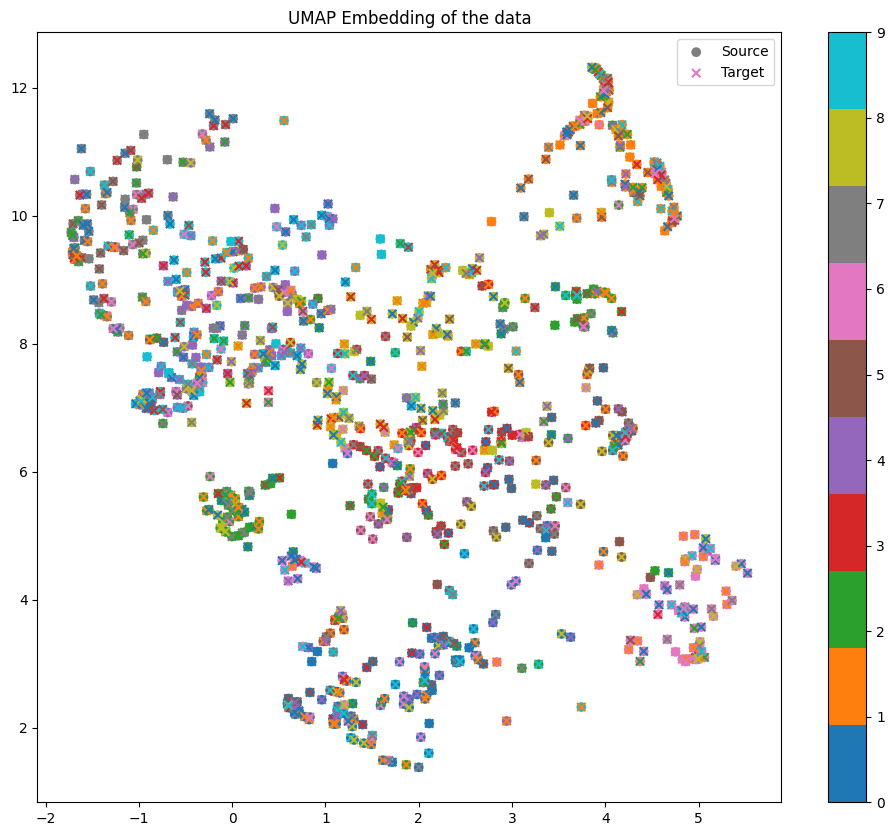

Visualizing before Subspace Alignment - T-SNE (SA)...


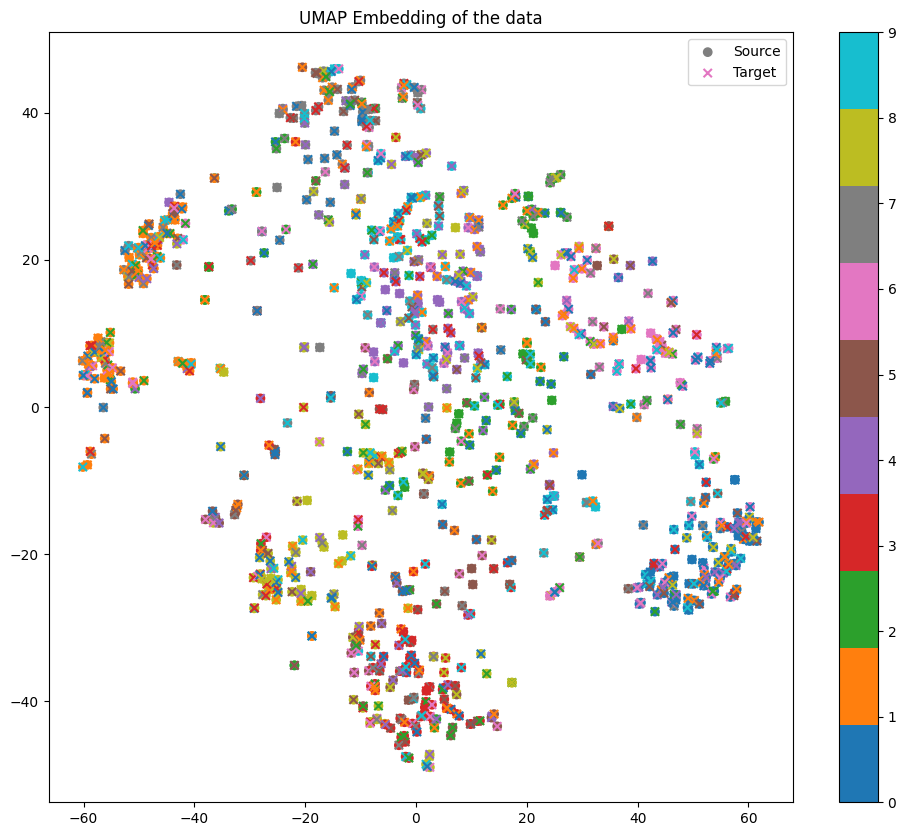

Applying Subspace Alignment ...
Visualizing after Subspace Alignment - T-SNE (SA)...


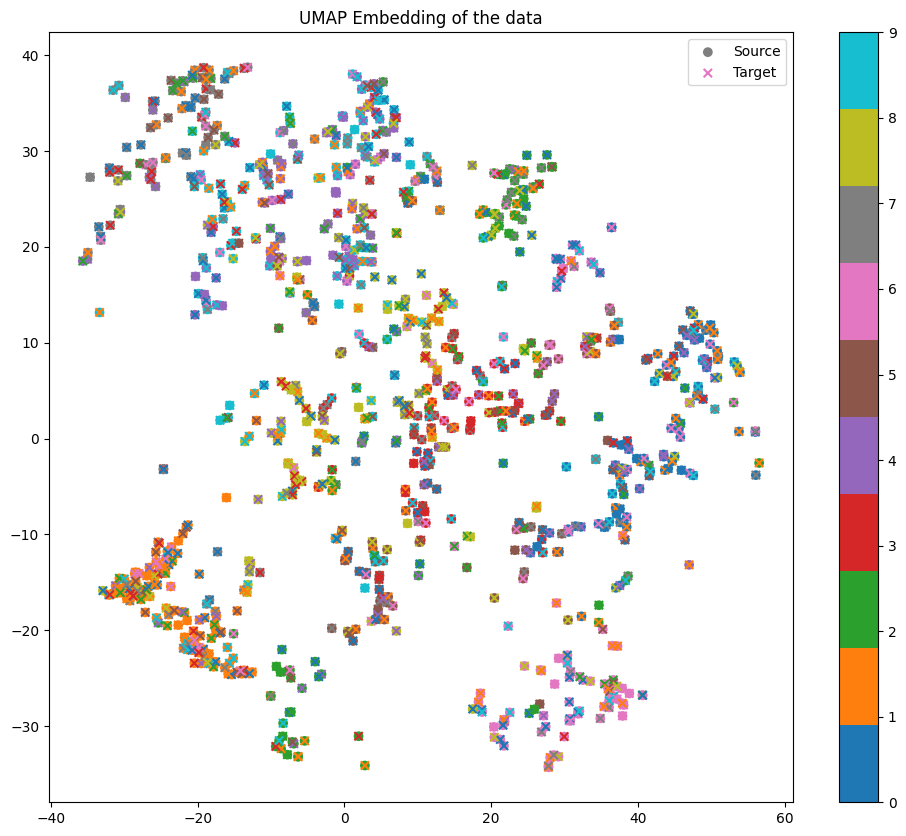

In [34]:
def visualize_adaptation(XSource, XTarget, ySource, yTarget, method="umap", title=""):
    """
    Visualize the source and target domain alignment using UMAP or t-SNE.

    Parameters:
    - XSource: Source data (e.g., training or test)
    - XTarget: Target data (e.g., training or test)
    - ySource: Labels for source data
    - yTarget: Labels for target data
    - method: "umap" or "tsne" for dimensionality reduction
    - title: Title of the plot
    """
    # Combine source and target data
    X_combined = np.vstack([XSource, XTarget])
    y_combined = np.hstack([ySource, yTarget])
    domain_labels = np.array(["Source"] * len(XSource) + ["Target"] * len(XTarget))

    # Apply dimensionality reduction
    if method == "umap":
        reducer = UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    elif method == "tsne":
        reducer = TSNE(n_components=2, perplexity=30, random_state=42)
    
    X_embedded = reducer.fit_transform(X_combined)

    X_embedded_S = X_embedded[:XSource.shape[0], :]
    X_embedded_T = X_embedded[:XTarget.shape[0], :]

    # Define distinct colors for source and target
    domain_colors = {"Source": "red", "Target": "blue"}

    # Plot the visualization
    plt.figure(3, (12, 10))

    plt.scatter(X_embedded_S[:,0],X_embedded_S[:,1],c=ySource,marker='o',cmap='tab10',label='Source')
    plt.scatter(X_embedded_T[:,0],X_embedded_T[:,1],c=yTarget,marker='x',cmap='tab10',label='Target')
    plt.legend()
    plt.colorbar()
    plt.title('UMAP Embedding of the data')
    plt.show()

# Visualization before and after SA
print("Visualizing before Subspace Alignment - UMAP (SA)...")
visualize_adaptation(XtrainS, XtrainT, ytrainS, ytrainT, method="umap", title="Before Subspace Alignment")

print("Applying Subspace Alignment ...")
XTrainSp, XTrainTp = SA(XtrainS, XtrainT, d=10)

print("Visualizing after Subspace Alignment - UMAP (SA)...")
visualize_adaptation(XTrainSp, XTrainTp, ytrainS, ytrainT, method="umap", title="After Subspace Alignment")

# Visualization before and after SA
print("Visualizing before Subspace Alignment - T-SNE (SA)...")
visualize_adaptation(XtrainS, XtrainT, ytrainS, ytrainT, method="tsne", title="Before Subspace Alignment")

print("Applying Subspace Alignment ...")
XTrainSp, XTrainTp = SA(XtrainS, XtrainT, d=10)

print("Visualizing after Subspace Alignment - T-SNE (SA)...")
visualize_adaptation(XTrainSp, XTrainTp, ytrainS, ytrainT, method="tsne", title="After Subspace Alignment")


**Question**: Repeat the same experiments for different Source and Target domains. Use at least the two followng configurations:

Source: MNIST, Target: USPS

Source MNIST, Target: SVHN

We consider the second setup where MNIST is the source and SVHN is the target



In [35]:
# Source domain
XtrainS2 = MNIST_Xtrain_res
ytrainS2 = MNIST_ytrain_res


# Target domain
XtrainT2 = SVHN_Xtrain_res
ytrainT2 = SVHN_ytrain_res

Ns=1000 # number of samples in source domain
Nt=1000 # number of samples in target domain

We have (before transformation), the following accuracies: 

In [36]:
accuracy = train_and_test_source_to_target(XtrainS2, ytrainS2, XtrainT2, ytrainT2)
accuracy2 = train_and_test_source_to_target(XtrainS2, ytrainS2, XtrainT2, ytrainT2, type="svm")

Accuracy on the target domain (no adaptation - log_reg): 13.90%
Accuracy on the target domain (no adaptation - svm): 11.90%


These results are consistent with what we figured out about the clear domain shift between MNIST and SVHN (which was not the case in the previous setting between MNIST and USPS).


Evaluating for d = 2 PCA components...
  Logistic Regression Accuracy: 0.0700
  SVM Accuracy: 0.0750
  MLP Accuracy: 0.0940

Evaluating for d = 5 PCA components...


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


  Logistic Regression Accuracy: 0.0790
  SVM Accuracy: 0.0840
  MLP Accuracy: 0.0930

Evaluating for d = 10 PCA components...
  Logistic Regression Accuracy: 0.0820
  SVM Accuracy: 0.0920
  MLP Accuracy: 0.0890

Evaluating for d = 20 PCA components...
  Logistic Regression Accuracy: 0.0770
  SVM Accuracy: 0.0660
  MLP Accuracy: 0.1000

Evaluating for d = 50 PCA components...
  Logistic Regression Accuracy: 0.0830
  SVM Accuracy: 0.0820
  MLP Accuracy: 0.0980

Evaluating for d = 70 PCA components...
  Logistic Regression Accuracy: 0.0800
  SVM Accuracy: 0.0880
  MLP Accuracy: 0.1090

Evaluating for d = 100 PCA components...
  Logistic Regression Accuracy: 0.1120
  SVM Accuracy: 0.0920
  MLP Accuracy: 0.1290

Evaluating for d = 120 PCA components...
  Logistic Regression Accuracy: 0.1310
  SVM Accuracy: 0.0960
  MLP Accuracy: 0.1370

Evaluating for d = 150 PCA components...
  Logistic Regression Accuracy: 0.1410
  SVM Accuracy: 0.0920
  MLP Accuracy: 0.1380

Evaluating for d = 200 PCA co

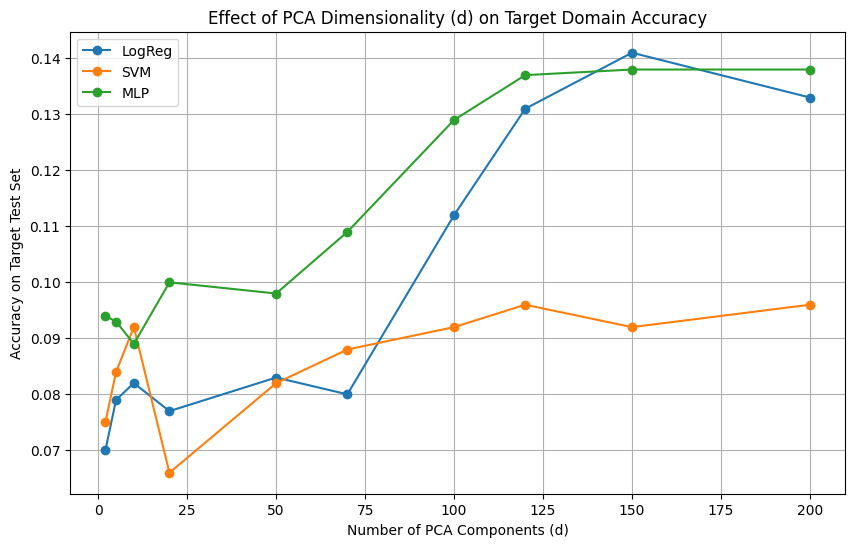


Comparing with Full-Dimensional Data Accuracy...
Full-Dimensional Data Accuracy (Logistic Regression): 0.1390


In [37]:
# Example Usage
# Assuming XTrainS, XTestS, XTrainT, XTestT, yTrainS, yTestT are pre-defined
d_values = [2, 5, 10, 20, 50, 70, 100, 120, 150, 200]
results = pca_experiment_with_plot(XtrainS2, XtrainT2, ytrainS2, ytrainT2, d_values)

# Compare with Full-Dimensional Data Accuracy
print("\nComparing with Full-Dimensional Data Accuracy...")
classifier_full = LogisticRegression(max_iter=1000)
classifier_full.fit(XtrainS2, ytrainS2)
yPredT_full = classifier_full.predict(XtrainT2)
full_accuracy = accuracy_score(ytrainT2, yPredT_full)
print(f"Full-Dimensional Data Accuracy (Logistic Regression): {full_accuracy:.4f}")

Here, the benchmark is an accuracy of roughly 12% without any pre-processing. It is already beaten with the previous method. Let's check with SA. 

Then with SA


Evaluating for d = 2 PCA components...
  Logistic Regression Accuracy: 0.0660
  SVM Accuracy: 0.0660
  MLP Accuracy: 0.0540

Evaluating for d = 5 PCA components...
  Logistic Regression Accuracy: 0.0930
  SVM Accuracy: 0.0660
  MLP Accuracy: 0.1240

Evaluating for d = 10 PCA components...
  Logistic Regression Accuracy: 0.0730
  SVM Accuracy: 0.0770
  MLP Accuracy: 0.0820

Evaluating for d = 20 PCA components...
  Logistic Regression Accuracy: 0.1070
  SVM Accuracy: 0.1920
  MLP Accuracy: 0.1150

Evaluating for d = 50 PCA components...
  Logistic Regression Accuracy: 0.0860
  SVM Accuracy: 0.0820
  MLP Accuracy: 0.1230

Evaluating for d = 70 PCA components...
  Logistic Regression Accuracy: 0.0980
  SVM Accuracy: 0.0800
  MLP Accuracy: 0.1010

Evaluating for d = 100 PCA components...
  Logistic Regression Accuracy: 0.1520
  SVM Accuracy: 0.0790
  MLP Accuracy: 0.1010

Evaluating for d = 120 PCA components...
  Logistic Regression Accuracy: 0.1570
  SVM Accuracy: 0.0820
  MLP Accuracy:

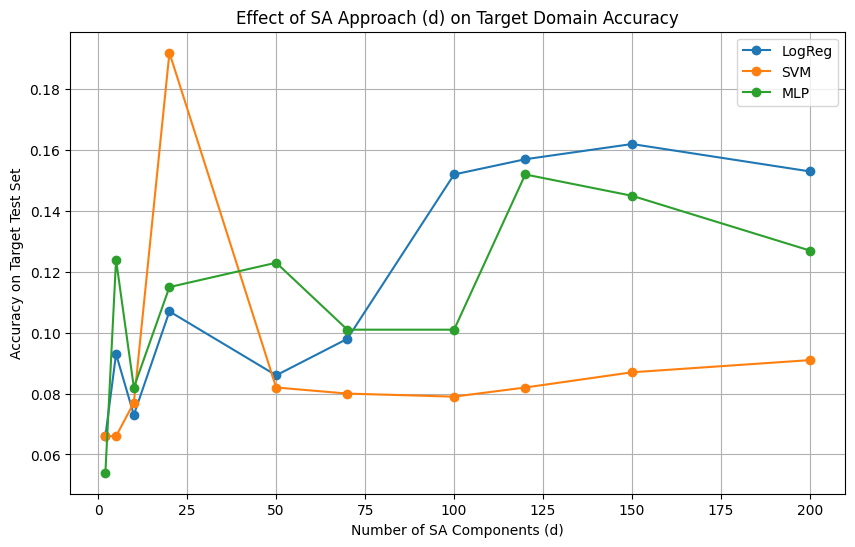

In [38]:
d_values =[2, 5, 10, 20, 50, 70, 100, 120, 150, 200]
results = evaluate_SA(XtrainS2, ytrainS2, XtrainT2, ytrainT2, d_values)

# Plotting the results
plt.figure(figsize=(10, 6))
for model in results.keys():
    accuracies = list(results[model].values())
    plt.plot(d_values, accuracies, marker='o', label=model)
plt.xlabel("Number of SA Components (d)")
plt.ylabel("Accuracy on Target Test Set")
plt.title("Effect of SA Approach (d) on Target Domain Accuracy")
plt.legend()
plt.grid()
plt.show()

We achieve even better results with the SVM and SA

Then the visualisation

Visualizing before Subspace Alignment (SA)...


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


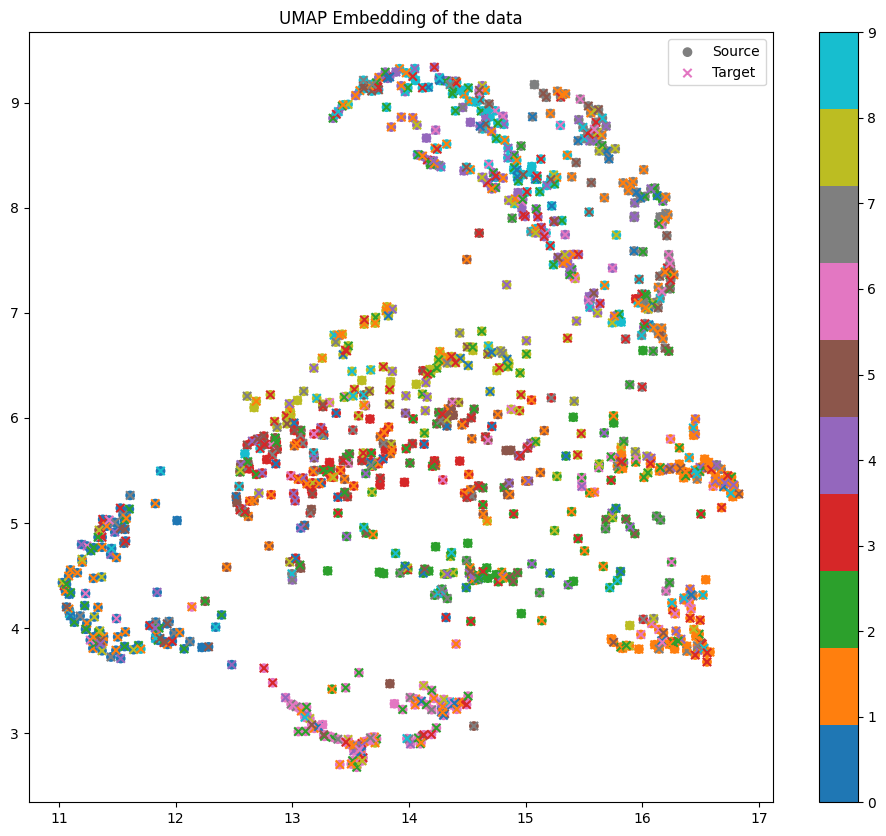

Applying Subspace Alignment...
Visualizing after Subspace Alignment (SA)...


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


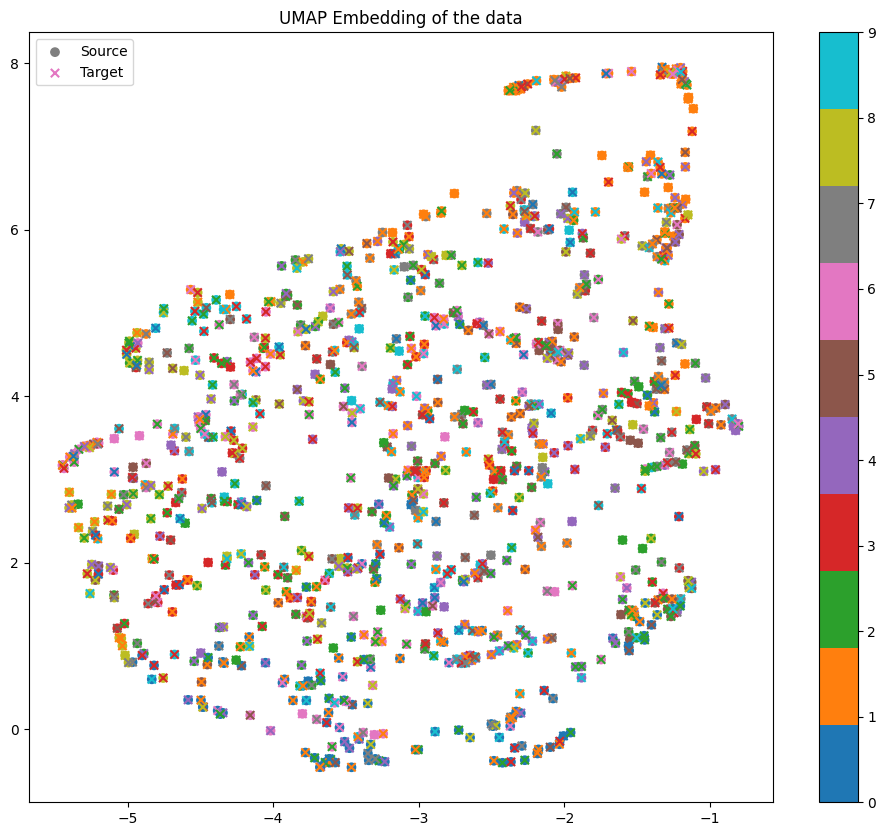

In [39]:
# Visualization before and after SA
print("Visualizing before Subspace Alignment (SA)...")
visualize_adaptation(XtrainS2, XtrainT2, ytrainS2, ytrainT2, method="umap", title="Before Subspace Alignment")

print("Applying Subspace Alignment...")
XTrainSp2, XTrainTp2 = SA(XtrainS2, XtrainT2, d=10)

print("Visualizing after Subspace Alignment (SA)...")
visualize_adaptation(XTrainSp2, XTrainTp2, ytrainS2, ytrainT2, method="umap", title="After Subspace Alignment")


**Question**: Comment the results

**Question**: What does it happen if you decrease the number of samples for the labeled training set? Is it expected based on the theory seen during the lecture ?


Testing with 1000 labeled samples...
  Logistic Regression Accuracy: 0.0730

Testing with 750 labeled samples...
  Logistic Regression Accuracy: 0.0760

Testing with 500 labeled samples...
  Logistic Regression Accuracy: 0.0700

Testing with 250 labeled samples...
  Logistic Regression Accuracy: 0.0760

Testing with 100 labeled samples...
  Logistic Regression Accuracy: 0.0600


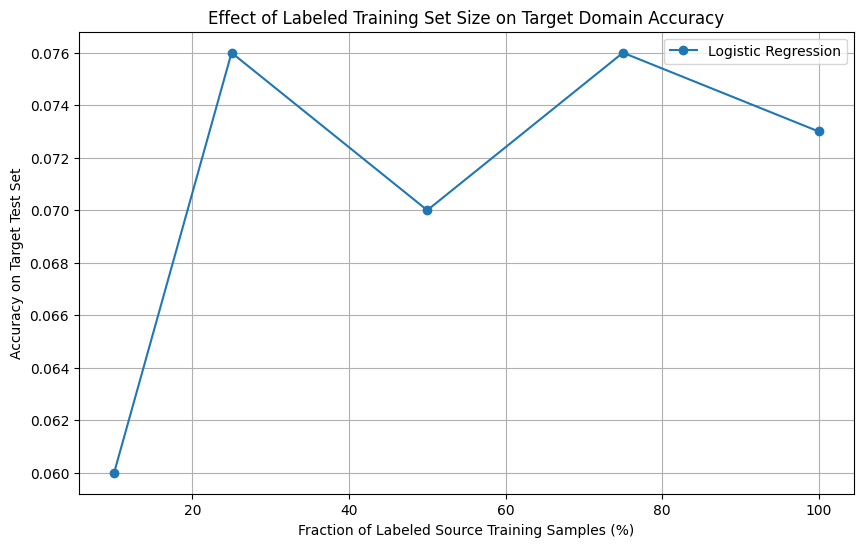

In [40]:
# Function to evaluate with reduced labeled training set size
def evaluate_reduced_samples(XTrainS, XTrainT, yTrainS, yTrainT, d, sample_fraction_values):
    results = {}
    
    for fraction in sample_fraction_values:
        print(f"\nTesting with {int(fraction * len(yTrainS))} labeled samples...")
        
        # Select a subset of the source domain training set
        n_samples = int(fraction * len(yTrainS))
        XTrainS_subset = XTrainS[:n_samples]
        XTrainT_subset = XTrainT[:n_samples]
        yTrainS_subset = yTrainS[:n_samples]
        yTrainT_subset = yTrainT[:n_samples]

        # Apply Subspace Alignment (SA)
        XTrainSp, XTrainTp = SA(XTrainS_subset, XTrainT_subset, d)

        # Train Logistic Regression (or other models) on the source domain
        clf_logreg = LogisticRegression(max_iter=1000)
        clf_logreg.fit(XTrainSp, yTrainS_subset)
        
        # Evaluate on the target domain
        yPredT_logreg = clf_logreg.predict(XTrainTp)
        acc_logreg = accuracy_score(yTrainT_subset, yPredT_logreg)
        
        results[fraction] = acc_logreg
        print(f"  Logistic Regression Accuracy: {acc_logreg:.4f}")
    
    return results

# Example usage
# Assuming XTrainS, XTestS, XTrainT, XTestT, yTrainS, yTestT are predefined

# Values of d to test
d = 10

# Different sample fractions to test (e.g., 100%, 75%, 50%, 25%, 10% labeled samples)
sample_fraction_values = [1.0, 0.75, 0.5, 0.25, 0.1]

# Perform the experiment
results = evaluate_reduced_samples(XtrainS2, XtrainT2, ytrainS2, ytrainT2, d, sample_fraction_values)

# Plotting the results
plt.figure(figsize=(10, 6))
fractions = [fraction * 100 for fraction in sample_fraction_values]  # Convert to percentage
accuracies = list(results.values())
plt.plot(fractions, accuracies, marker='o', label="Logistic Regression")
plt.xlabel("Fraction of Labeled Source Training Samples (%)")
plt.ylabel("Accuracy on Target Test Set")
plt.title("Effect of Labeled Training Set Size on Target Domain Accuracy")
plt.grid()
plt.legend()
plt.show()


**Optional**: You can test other methods using the `adapt`library. See `https://adapt-python.github.io/adapt/`. You will need Tensorflow==2.15

Here, you can test the MDD and DANN methods using a very simple architecture for both the encoder and discriminator.

In the following, I had an issue with TensorFlow (since I always use PyTorch). That being said, I have read and understood the part on MDD and DANN in the slides. 

In [3]:
# !pip uninstall tensorflow -y
# !pip install tensorflow==2.5

In [ ]:
from adapt.feature_based import MDD
from tensorflow.keras import layers, models

# Example encoder (you can modify this as per your architecture)
encoder = models.Sequential([
    layers.InputLayer(input_shape=(XtrainS.shape[1],)),  # input layer
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu')
])

# Example task (a simple classifier)
task = models.Sequential([
    layers.Dense(10, activation='softmax')  # Assuming 10 classes
])

# Initialize the MDD model
model = MDD(encoder=encoder, task=task, lambda_=0.1, gamma=4., Xt=XtrainT, metrics=["accuracy"], random_state=0)

# Compile the MDD model using the 'adapt' library's method
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Fit the model
model.fit(XtrainS, ytrainS, epochs=100, verbose=0)

# Evaluate the model on the source domain
print(f"MDD model accuracy on source domain: {model.score(XtrainS, ytrainS)}")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from adapt.feature_based import DANN

# Define the encoder network
encoder_dann = Sequential([
    Dense(64, activation='relu', input_shape=(XtrainS.shape[1],)),
    Dense(32, activation='relu')
])

# Define the task network (classifier)
task_dann = Sequential([
    Dense(10, activation='softmax', input_shape=(32,))  # Assuming 10 classes
])

# Define the discriminator network
discriminator = Sequential([
    Dense(32, activation='relu', input_shape=(32,)),  # Input matches the encoder's output size
    Dense(1, activation='sigmoid')  # Binary classification: Source or Target
])

# Set Optimizer
optimizer = Adam(learning_rate=0.001, decay=1e-6)

# Initialize the DANN model
model_dann = DANN(
    encoder=encoder_dann,
    task=task_dann,
    discriminator=discriminator,
    lambda_=1.0,  # Weight for adversarial loss
    metrics=["accuracy"]
)

# Compile the model
model_dann.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model (ensure Xt is passed in `fit`)
model_dann.fit(XtrainS, ytrainS, Xt=XtrainT, epochs=100, verbose=0)

# Evaluate the DANN model
accuracy = model_dann.score(XtrainS, ytrainS)
print(f"DANN model accuracy on source domain: {accuracy:.4f}")

**Question (Optional)**: try to use a more complex architecture (for instance a pre-trained model) for both the encoder and discriminator. Be careful, the adapt library is written in TensorFlow...